In [1]:
from glob import glob
import json
import os
import pickle
import sys
import time

import cv2
import h5py
from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

#### Change this path to point to your code

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind
from tbd_eeg.tbd_eeg.data_analysis.Utilities.behavior_movies import Movie, get_sync_frame_times
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import subsample_lfp, remove_lfp_offset
# from tbd_eeg.tbd_eeg.data_analysis.eeg_preprocessing import qualitycheck_trials

In [5]:
%matplotlib widget

#### Plot electrodes

### Load experiment

In [6]:
recfolder = r'R:\mouse771425\THstim_d2_2024-11-22_10-49-58\experiment1\recording1'
# recfolder = r'Q:\mouse771424\THstim_d2_2024-11-15_10-51-49\experiment1\recording1'
# exp = EEGexp(recfolder, preprocess=True, make_stim_csv=True)
exp = EEGexp(recfolder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [7]:
plotsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\THstim_project\pilot videos'

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

THstim_d2


### Load events

In [8]:
# stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = pd.read_csv(
    exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):])

In [9]:
stim_log.tail()

,stim_type,parameter,duration,onset,offset,sweep
10,freq100Hz,100,40,3278.65941,3318.65962,0
11,freq100Hz,100,40,3654.02041,3694.02061,1
12,freq100Hz,100,40,3803.45689,3843.45710,1
13,freq100Hz,100,40,4133.85983,4173.86004,2
14,freq100Hz,100,40,4254.05853,4294.05874,2


## Load EEG data

### Plot some EEG signal

## Load LFP signal

In [10]:
exp.experiment_data

['probeA_sorted',
 'probeD_sorted',
 'probeE_sorted',
 'probeF_sorted',
 'recording1']

In [11]:
probei = 'probeF'
plotch = np.array([200])

lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
lfp_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')

# lfpdata = lfp_mm[:, plotch] * exp.ephys_params[probei]['bit_volts']

In [12]:
subsample_lfp = False
subsampling_factor = 5
if subsample_lfp:
    print('Subsampling')
    lfp_ts = lfp_ts[::subsampling_factor]
    new_samp_rate = exp.ephys_params[probei]['lfp_sample_rate'] / subsampling_factor
    lfpdata = subsample_lfp(lfp_mm, plotch, subsampling_factor)
    ## Remove DC offset ##
    lfpdata = remove_lfp_offset(lfpdata, new_samp_rate, 0.1, 1) * exp.ephys_params[probei]['bit_volts']
else:
    lfpdata = lfp_mm[:, plotch] * exp.ephys_params[probei]['bit_volts']

In [13]:
eventind = 1
stimevent = stim_log.iloc[eventind]
deltat = 10.0
plotwin = [stimevent.onset - deltat, stimevent.offset + deltat]

Text(0, 0.5, 'LFP voltage (uV)')

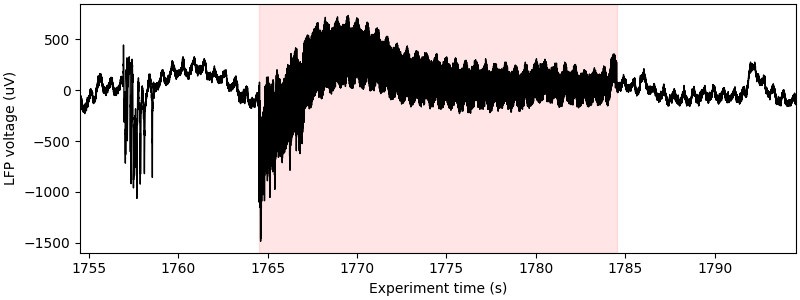

In [14]:
tsinds = np.nonzero((lfp_ts > plotwin[0]) & (lfp_ts < plotwin[1]))[0]

fig, ax = plt.subplots(figsize=(8,3), constrained_layout=True)
ax.axvspan(stimevent.onset, stimevent.offset, color='r', alpha=0.1)
ax.plot(lfp_ts[tsinds], lfpdata[tsinds], color='k', linewidth=1.0)
ax.set_xlim(plotwin)
ax.set_xlabel('Experiment time (s)')
ax.set_ylabel('LFP voltage (uV)')

## Load behavior videos

In [15]:
pupil_video = Movie(
    filepath = exp.pupilmovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'eyetracking'
)
pupil_ts = pupil_video.sync_timestamps
body_video = Movie(
    filepath = exp.bodymovie_file,
    sync_filepath = exp.sync_file,
    sync_channel = 'behavior'
)
body_ts = body_video.sync_timestamps

C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:40: UserWarning: NONMATCHING timestamp counts
There are 151810 timestamps in sync and 151858 timestamps in the associated camera file
these should match
  warnings.warn(f'NONMATCHING timestamp counts\nThere are {len(self.sync_timestamps)} timestamps in sync and {len(self.timestamps_from_file)} timestamps in the associated camera file\nthese should match' )
C:\Users\lesliec\code\tbd_eeg\tbd_eeg\data_analysis\Utilities\behavior_movies.py:40: UserWarning: NONMATCHING timestamp counts
There are 302721 timestamps in sync and 302817 timestamps in the associated camera file
these should match
  warnings.warn(f'NONMATCHING timestamp counts\nThere are {len(self.sync_timestamps)} timestamps in sync and {len(self.timestamps_from_file)} timestamps in the associated camera file\nthese should match' )


In [16]:
print(pupil_ts[:10])
print(np.diff(pupil_ts)[:10])

[14.47345 14.49949 14.50122 14.53245 14.56564 14.59907 14.63246 14.66576
 14.69964 14.73284]
[0.02604 0.00173 0.03123 0.03319 0.03343 0.03339 0.0333  0.03388 0.0332
 0.22368]


In [17]:
print(body_ts[:10])
print(np.diff(body_ts)[:10])

[14.52416 14.53641 14.53966 14.55653 14.57329 14.58972 14.60652 14.62329
 14.64002 14.65685]
[0.01225 0.00325 0.01687 0.01676 0.01643 0.0168  0.01677 0.01673 0.01683
 0.29814]


## Make video with LFP signal

In [30]:
eventind = 13
stimevent = stim_log.iloc[eventind]
deltat = 10.0
plotwin = [stimevent.onset - deltat, stimevent.offset + deltat]

In [31]:
plotwin

[4123.85983, 4183.86004]

In [32]:
def update(clock_time):
    
    # body cam movie
    bplot.set_data(body_video.get_frame(time=clock_time, timestamps='sync'))

    # pupil cam movie
    pplot.set_data(pupil_video.get_frame(time=clock_time, timestamps='sync'))

    # LFP plot
    spline.set_data([clock_time, clock_time], [-1,1])

    # text
    if clock_time >= stimevent.onset:
        if clock_time < stimevent.offset:
            event_text.set_text('STIM ON')
            event_text.set_color('g')
        else:
            event_text.set_text('STIM OFF')
            event_text.set_color('r')
    
    return fig

In [33]:
movie_name = os.path.join(
    plotsavedir,
    'mouse{}_{}_videosLFP_{}-{:d}ua-{:d}s_event{:d}_2x.mp4'.format(exp.mouse, exp_tag, stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))
print(movie_name)

C:\Users\lesliec\OneDrive - Allen Institute\data\plots\THstim_project\pilot videos\mouse771425_THstim_d2_videosLFP_freq100Hz-100ua-40s_event13_2x.mp4


In [34]:
frame_times = pupil_ts[np.nonzero((pupil_ts > plotwin[0]) & (pupil_ts < plotwin[1]))[0]]
print(len(frame_times))

1799


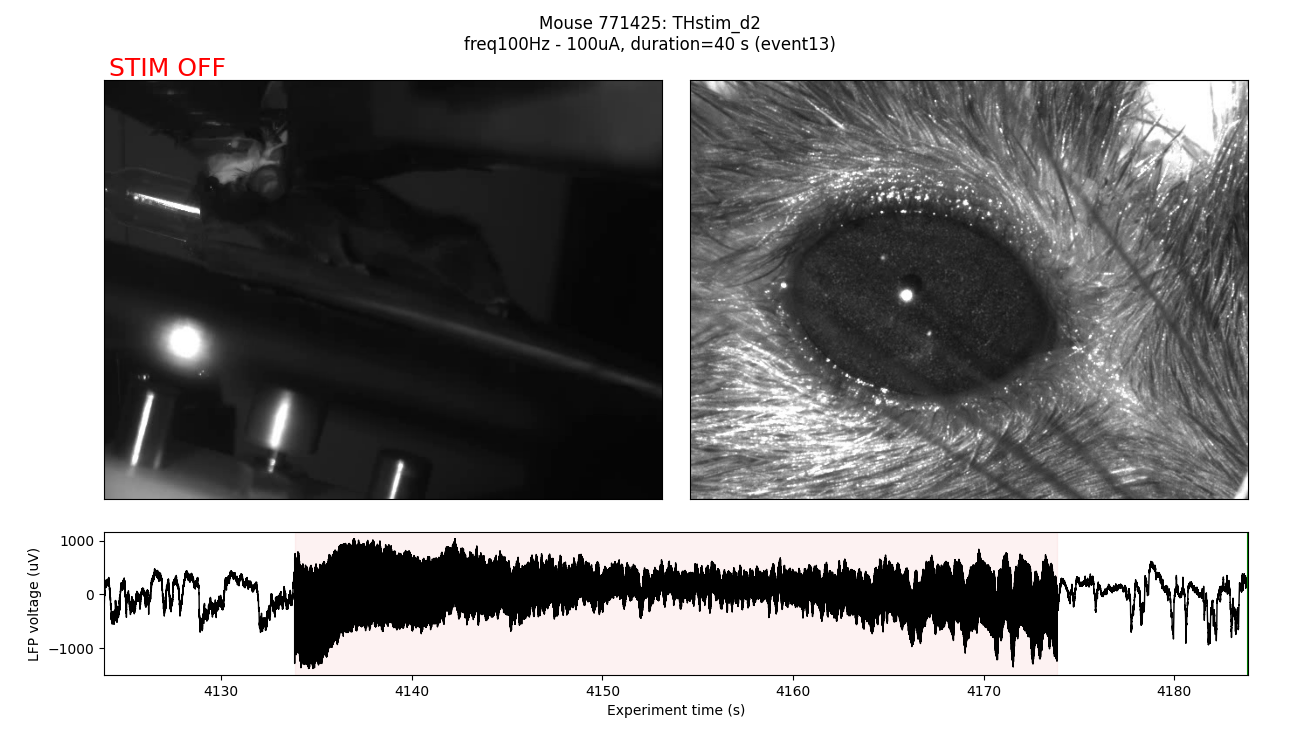

In [35]:
fig = plt.figure(figsize=(13, 7.5))
fig.patch.set_facecolor('whitesmoke')

# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1], left=0.08, right=0.96, bottom=0.1, top=0.9, wspace=0.05, hspace=0.1)
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_lfp = fig.add_subplot(gs[1, :])

# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)

# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)

# LFP plot
tsinds = np.nonzero((lfp_ts > plotwin[0]) & (lfp_ts < plotwin[1]))[0]
ax_lfp.axvspan(stimevent.onset, stimevent.offset, color='lightcoral', alpha=0.1)
ax_lfp.plot(lfp_ts[tsinds], lfpdata[tsinds], color='k', linewidth=1.0)
ax_lfp.set_xlim(plotwin)
ax_lfp.set_xlabel('Experiment time (s)')
ax_lfp.set_ylabel('LFP voltage (uV)')
spline = ax_lfp.axvline(plotwin[0], color='g')

fig.suptitle('Mouse {}: {}\n{} - {:d}uA, duration={:d} s (event{:d})'.format(exp.mouse, exp_tag, stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))
event_text = ax_body.text(5, -5, 'STIM OFF', fontsize=18, color='r')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=200, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=60, extra_args=['-vcodec', 'libx264'], dpi=300)

## Make video (videos only)

In [47]:
eventind = 0
stimevent = stim_log.iloc[eventind]
deltat = 5.0
plotwin = [stimevent.onset - deltat, stimevent.offset + deltat]

In [55]:
plotwin

[2072.24164, 2102.24175]

In [58]:
def update(clock_time):
    
    # body cam movie
    bplot.set_data(body_video.get_frame(time=clock_time, timestamps='sync'))

    # pupil cam movie
    pplot.set_data(pupil_video.get_frame(time=clock_time, timestamps='sync'))

    # text
    if clock_time >= stimevent.onset:
        if clock_time < stimevent.offset:
            event_text.set_text('STIM ON')
            event_text.set_color('g')
        else:
            event_text.set_text('STIM OFF')
            event_text.set_color('r')
    
    return fig

In [59]:
movie_name = os.path.join(
    plotsavedir,
    'mouse{}_{}_videos_{}-{:d}ua-{:d}s_event{:d}.mp4'.format(exp.mouse, exp_tag, stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))
print(movie_name)

C:\Users\lesliec\OneDrive - Allen Institute\data\plots\THstim_project\pilot videos\mouse771424_THstim_d1_videos_freq50Hz-10ua-20s_event0.mp4


In [60]:
frame_times = pupil_ts[np.nonzero((pupil_ts > plotwin[0]) & (pupil_ts < plotwin[1]))[0]]
print(len(frame_times))

900


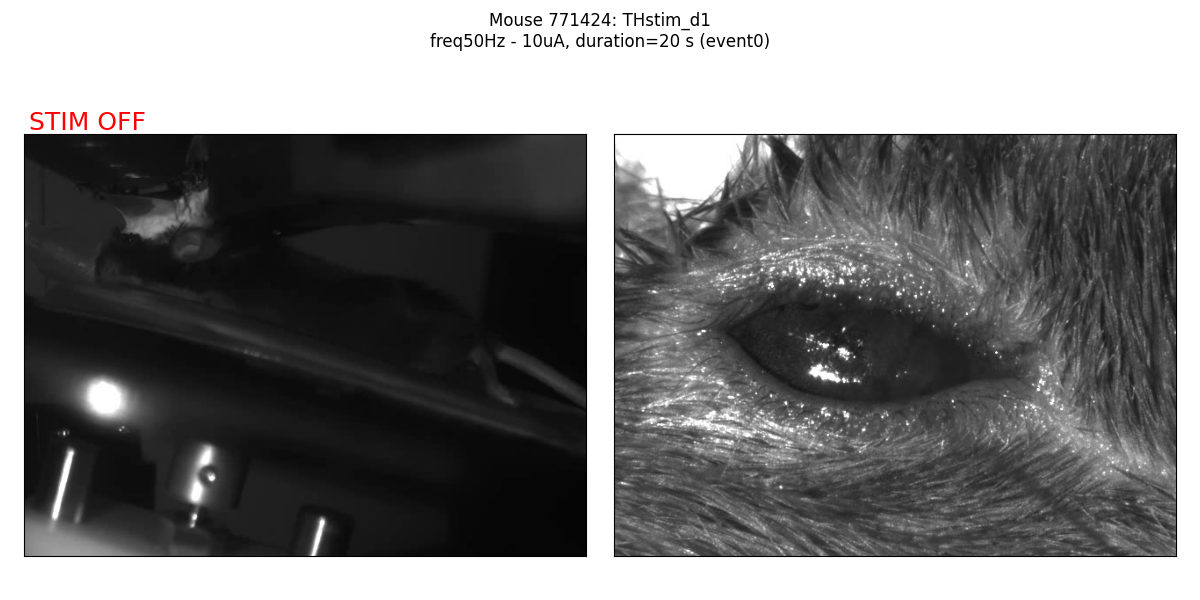

In [61]:
fig = plt.figure(figsize=(12, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(1, 2, figure=fig, left=0.02, right=0.98, bottom=0.05, top=0.8, wspace=0.05)
ax_body = fig.add_subplot(gs[0])
ax_eye = fig.add_subplot(gs[1])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)

fig.suptitle('Mouse {}: {}\n{} - {:d}uA, duration={:d} s (event{:d})'.format(exp.mouse, exp_tag, stimevent.stim_type, stimevent.parameter, stimevent.duration, eventind))
event_text = ax_body.text(5, -5, 'STIM OFF', fontsize=18, color='r')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=200, blit=False)
# anim.save(movie_name, writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

### Set up video clips

## Make video

In [23]:
def update(clock_time):
    
    # body cam movie
    bplot.set_data(body_video.get_frame(time=clock_time, timestamps='sync'))

    # pupil cam movie
    pplot.set_data(pupil_video.get_frame(time=clock_time, timestamps='sync'))

    # eeg plot
    # spline.set_data([clock_time - SWDevent.onset, clock_time - SWDevent.onset], [-1,1])
    spline.set_data([clock_time, clock_time], [-1,1])
    
    return fig

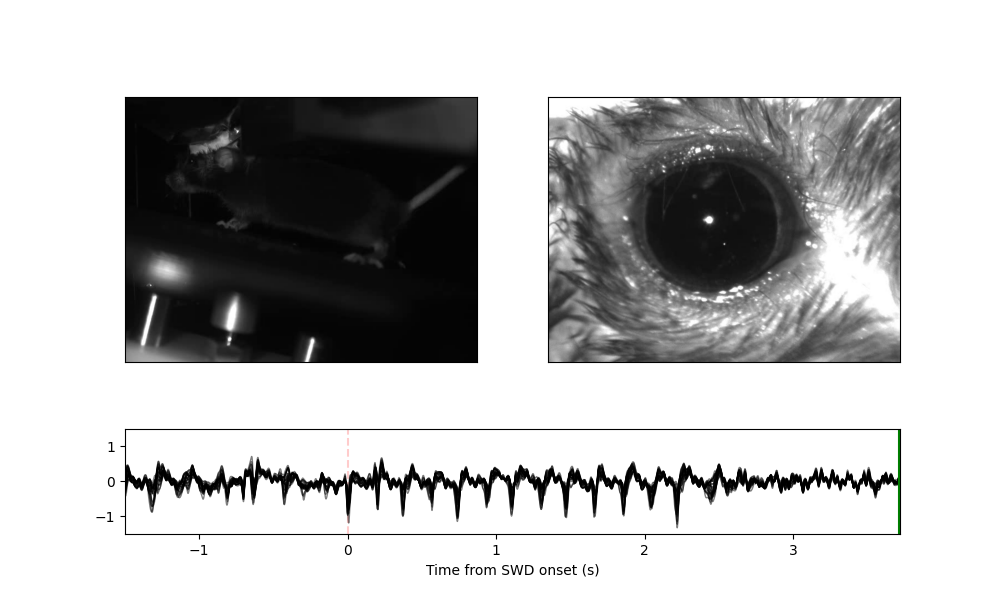

In [32]:
SWDind = 512
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.5
plotwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

movie_name = os.path.join(plotsavedir, 'SWD{:d}_EEG_videos.mp4'.format(SWDind))
frame_times = pupil_ts[np.nonzero((pupil_ts > plotwin[0]) & (pupil_ts < plotwin[1]))[0]]

fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1])
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_eeg = fig.add_subplot(gs[1, :])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=plotwin[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)
# EEG plot
eeginds = np.nonzero((eeg_ts > plotwin[0]) & (eeg_ts < plotwin[1]))[0]
ax_eeg.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax_eeg.plot(eeg_ts[eeginds] - SWDevent.onset, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
ax_eeg.set_xlim(plotwin - SWDevent.onset)
ax_eeg.set_xlabel('Time from SWD onset (s)')
ax_eeg.set_ylim([-1.5, 1.5])
spline = ax_eeg.axvline(plotwin[0] - SWDevent.onset, color='g')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=60, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=10, extra_args=['-vcodec', 'libx264'], dpi=300)

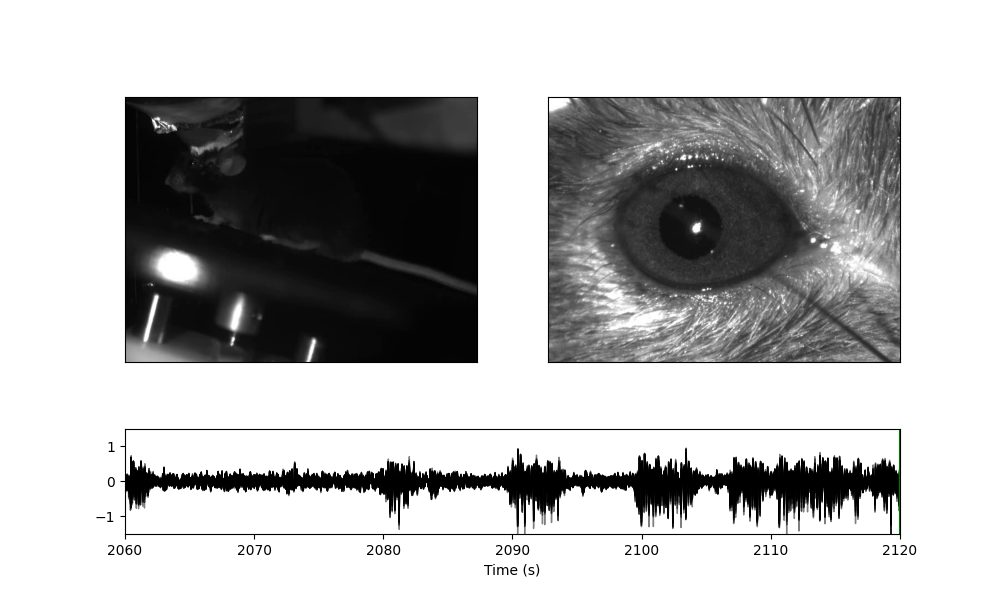

In [24]:
window = [2060, 2120]

movie_name = os.path.join(plotsavedir, 'window2_EEG_videos.mp4')
frame_times = pupil_ts[np.nonzero((pupil_ts > window[0]) & (pupil_ts < window[1]))[0]]

fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('whitesmoke')
# make grid for subplots
gs = GridSpec(2, 2, figure=fig, height_ratios=[3, 1])
ax_body = fig.add_subplot(gs[0, 0])
ax_eye = fig.add_subplot(gs[0, 1])
ax_eeg = fig.add_subplot(gs[1, :])
# body cam movie
bplot = ax_body.imshow(body_video.get_frame(time=window[0], timestamps='sync'))
ax_body.get_xaxis().set_visible(False)
ax_body.get_yaxis().set_visible(False)
# pupil cam movie
pplot = ax_eye.imshow(pupil_video.get_frame(time=window[0], timestamps='sync'))
ax_eye.get_xaxis().set_visible(False)
ax_eye.get_yaxis().set_visible(False)
# EEG plot
eeginds = np.nonzero((eeg_ts > window[0]) & (eeg_ts < window[1]))[0]
ax_eeg.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax_eeg.plot(eeg_ts[eeginds], filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
ax_eeg.set_xlim(window)
ax_eeg.set_xlabel('Time (s)')
ax_eeg.set_ylim([-1.5, 1.5])
spline = ax_eeg.axvline(window[0], color='g')

## from Ethan
anim = animation.FuncAnimation(fig, update, init_func=None, frames=frame_times, interval=60, blit=False)
anim.save(movie_name, writer='ffmpeg', fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

### Load units and spikes

In [14]:
fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,other-TH
1,B4,probeB,1,3640,0.508208,AMv,253,179,195,other-TH
2,B9,probeB,3,3620,0.590620,AMv,253,178,195,other-TH
3,B10,probeB,4,3600,0.480737,AMv,253,177,194,other-TH
4,B11,probeB,5,3600,0.480737,AMv,253,177,194,other-TH


In [15]:
for pregi in np.unique(unit_info['parent_region'].values):
    pudf = unit_info[unit_info['parent_region'] == pregi]
    print('{}: {:d} units'.format(pregi, len(pudf)))

HIP: 113 units
MO: 73 units
PAL: 69 units
RT-TH: 12 units
SM-TH: 59 units
SS: 135 units
STR: 97 units
VIS: 24 units
other-TH: 208 units


### Load LFP

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeD', 'probeF']


In [ ]:
LFP_traces = {}
for pbi, probei in enumerate(probe_list):

In [17]:
probei = 'probeD'

lfp_ts = np.load(exp.ephys_params[probei]['lfp_timestamps'])
lfp_mm = np.memmap(exp.ephys_params[probei]['lfp_continuous'], dtype='int16', shape=(lfp_ts.size, exp.ephys_params[probei]['num_chs']), mode='r')

In [18]:
print(lfp_ts.shape)
print(lfp_mm.shape)

(16506874,)
(16506874, 384)


In [19]:
with open(exp.ephys_params[probei]['probe_info']) as data_file:
    data = json.load(data_file)
    
## Get info ##
npx_allch = np.array(data['channel']) # this is an array from 0 to 384
surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
air_ch = int(data['air_channel']) # the electrode at the ACSF/air border
allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip
ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"

print(surface_ch)
print(air_ch)

370
384


In [20]:
allch_areas = np.array(data['area_ch'])
print(np.unique(allch_areas))

['CP' 'RT' 'SSp-bfd1' 'SSp-bfd2/3' 'SSp-bfd4' 'SSp-bfd5' 'SSp-bfd6a'
 'SSp-bfd6b' 'VAL' 'VL' 'VPL' 'ccb' 'em' 'fi' 'fiber tracts' 'null' 'or'
 'st']


In [30]:
ROI = 'SSp'
ROImask = [True if ROI in x else False for x in allch_areas]
print(np.sum(ROImask))

125


Testing

In [23]:
SWDind = 40
SWDevent = autoSWD_df.iloc[SWDind]
deltat = 1.0

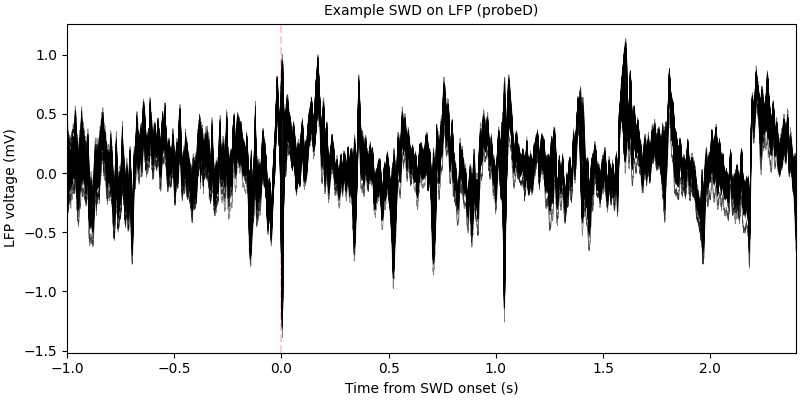

In [26]:
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]

fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
ax.axvline(0, color='r', linestyle='dashed', alpha=0.2)
ax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
# ax.plot(lfp_ts[tsinds] - timezero, saline_ref[tsinds] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='m', linewidth=1.0, alpha=0.8)
ax.set_xlim(pwin - timezero)
ax.set_xlabel('Time from SWD onset (s)')
ax.set_ylabel('LFP voltage (mV)')
ax.set_title('Example SWD on LFP ({})'.format(probei))

### SAVE ###
fig_name = 'SWD_LFPonly_example{:d}.png'.format(SWDind)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Plot an SWD event

In [32]:
plot_regions = ['other-TH', 'SM-TH', 'RT-TH', 'VIS', 'SS', 'MO']

In [53]:
SWDind = 257
SWDevent = autoSWD_df.iloc[SWDind]
print(SWDevent.duration)

1.339186593469094


In [59]:
deltat = 1.0 # time around SWD to plot, s

Plot EEG + LFP + all region raster

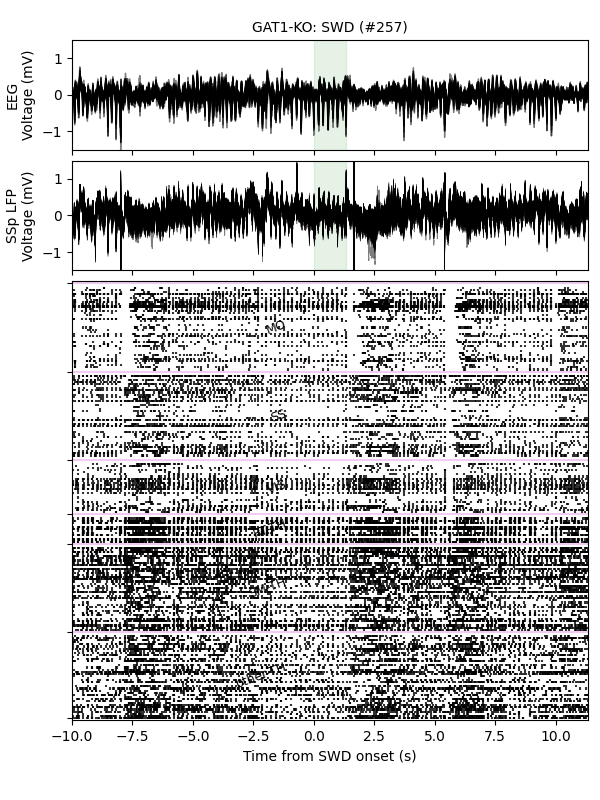

In [60]:
## Plot one half-slide ##
timezero = SWDevent.onset
pwin = [SWDevent.onset - deltat, SWDevent.offset + deltat]
umax = 40

fig = plt.figure(figsize=(6, 8)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=3, left=0.12, right=0.98, top=0.95, bottom=0.1, hspace=0.05, height_ratios=[1, 1, 4])
EEGax = fig.add_subplot(gs[0])
LFPax = fig.add_subplot(gs[1])
rasterax = fig.add_subplot(gs[2])

## Plot EEG ##
eeginds = np.nonzero((eeg_ts > pwin[0]) & (eeg_ts < pwin[1]))[0]
EEGax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
EEGax.plot(eeg_ts[eeginds] - timezero, filt_data[eeginds, :][:, GOOD_CHS], color='k', linewidth=1.0, alpha=0.5)
EEGax.set_xlim(pwin - timezero)
EEGax.set_xticklabels([])
EEGax.set_ylim([-1.5, 1.5])
# EEGax.set_ylim([-0.25, 0.25])
EEGax.set_ylabel('EEG\nVoltage (mV)')
EEGax.set_title('GAT1-KO: SWD (#{:d})'.format(SWDind))
# EEGax.set_title('Wild type (not litter mate): spontaneous activity')

## Plot LFP ##
tsinds = np.nonzero((lfp_ts > pwin[0]) & (lfp_ts < pwin[1]))[0]
LFPax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
LFPax.plot(lfp_ts[tsinds] - timezero, lfp_mm[tsinds, :][:, ROImask] * exp.ephys_params[probei]['bit_volts'] * 1e-3, color='k', linewidth=0.5, alpha=0.5)
LFPax.set_xlim(pwin - timezero)
LFPax.set_xticklabels([])
LFPax.set_ylim([-1.5, 1.5])
LFPax.set_ylabel('{} LFP\nVoltage (mV)'.format(ROI))

## Plot raster ##
# rasterax.axvspan(0, SWDevent.duration, color='g', alpha=0.1)
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwin[0]) & (uspiketimes < pwin[1]))[0]
        ]
        rasterax.eventplot(SWDspikes - timezero, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(-1.05, last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwin - timezero)
rasterax.set_xlabel('Time from SWD onset (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
fig_name = 'SWD_EEG_LFP_NPX_example{:d}.png'.format(SWDind)
# fig_name = 'spont_EEG_NPX_example.png'
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)